# 實作DCGAN演算法，產生手寫阿拉伯數字
### 程式修改自[Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan)

In [1]:
# To generate GIFs
!pip install -q imageio

In [2]:
# 載入相關套件
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time
from IPython import display

## 取得訓練資料，轉為TensorFlow Dataset

In [3]:
# 取得 MNIST 訓練資料
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# 像素標準化
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # 使像素值介於 [-1, 1]

# 參數設定
BUFFER_SIZE = 60000 # 緩衝區大小
BATCH_SIZE = 256    # 訓練批量

# 轉為 Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images) \
        .shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(BUFFER_SIZE).cache()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 定義生成神經網路

In [31]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input((100,)))
    model.add(layers.Dense(7*7*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # None 代表批量不檢查

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1),
                                     padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2),
                     padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

## 建立並測試生成神經網路

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


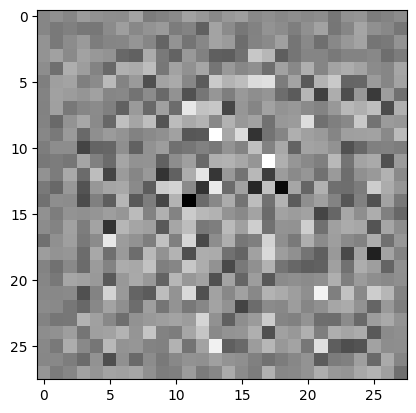

In [30]:
# 測試生成神經網路
generator = make_generator_model()

# 測試產生的雜訊
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# 顯示雜訊生成的圖像
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## 定義判别神經網路

In [35]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input([28, 28, 1]))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

## 建立並測試判别神經網路

In [37]:
discriminator = make_discriminator_model()

# 真實的影像預測值會是較大的值，生成的影像預測值會是較小的值
decision = discriminator(generated_image)
print (f'預測值={decision[0][0]}')

預測值=-0.0011681297328323126


In [40]:
# 測試真實的影像5筆
decision = discriminator(train_images[0:5])
print (f'預測值={decision}')

預測值=[[ 0.12165608]
 [ 0.14320901]
 [-0.00153188]
 [ 0.13788301]
 [ 0.11824991]]


## 定義損失函數及優化器

In [45]:
# 定義損失函數為二分類交叉熵
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 定義判别神經網路損失函數為 真實影像 + 生成影像 的損失函數
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# 定義生成神經網路損失函數為 生成影像 的損失函數
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 優化器均為 Adam
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 設定檢查點

In [46]:
# 在檢查點模型存檔
checkpoint_dir = './dcgan_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                  discriminator_optimizer=discriminator_optimizer,
                  generator=generator,
                  discriminator=discriminator)

## 參數設定

In [11]:
# 參數設定
EPOCHS = 50                    # 訓練執行週期
noise_dim = 100                # 雜訊向量大小
num_examples_to_generate = 16  # 生成筆數

# 產生亂數(雜訊)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

## 定義梯度下降函數

In [12]:
# 定義梯度下降，分別對判别神經網路、生成神經網路進行訓練
@tf.function  # 產生運算圖
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 生成神經網路進行訓練
        generated_images = generator(noise, training=True)

        # 判别神經網路進行訓練
        real_output = discriminator(images, training=True)           # 真實影像
        fake_output = discriminator(generated_images, training=True) # 生成影像

        # 計算損失
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # 梯度下降
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                    discriminator.trainable_variables)

    # 更新權重
    generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                discriminator.trainable_variables))

## 定義訓練函數

In [13]:
# 定義訓練函數
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # 產生圖像
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # 每 10 個執行週期存檔一次
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('epoch {} 花費 {} 秒'.format(epoch + 1, time.time()-start))

    # 顯示最後結果
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [14]:
# 產生圖像並存檔
def generate_and_save_images(model, epoch, test_input):
    # 預測
    predictions = model(test_input, training=False)

    # 顯示 4x4 的格子
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

    # 存檔
    plt.savefig('./GAN_result/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## 訓練模型

In [15]:
import os
if not os.path.exists('./GAN_result'):
  os.makedirs('./GAN_result')

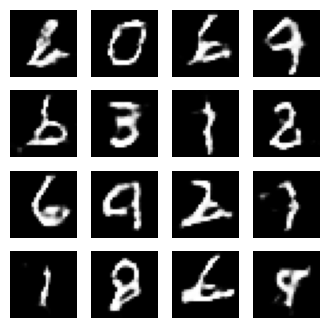

In [16]:
train(train_dataset, EPOCHS)

## 顯示最後結果

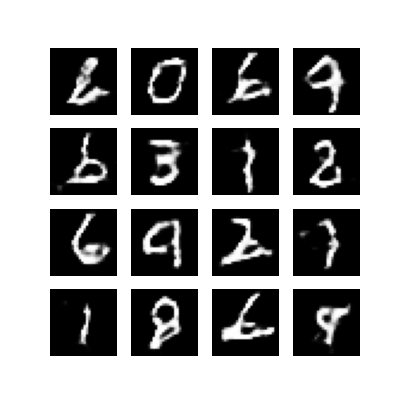

In [17]:
# 顯示最後結果
def display_image(epoch_no):
    return PIL.Image.open('./GAN_result/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

## 將訓練過程的存檔圖像轉為GIF 檔，並顯示GIF檔

In [ ]:
anim_file = './GAN_result/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./GAN_result/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

## 先安裝tensorflow-docs套件，以播放GIF檔

In [20]:
!pip install tensorflow-docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 4.2 MB/s eta 0:00:00


## 顯示 GIF 檔


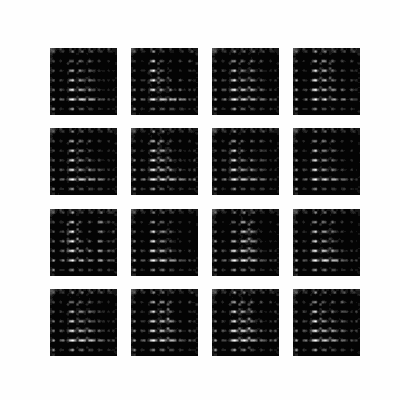

In [21]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [23]:
from google.colab import files
files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 還原(restore)模型

In [47]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 測試還原後是否仍可產生訓練後的成果

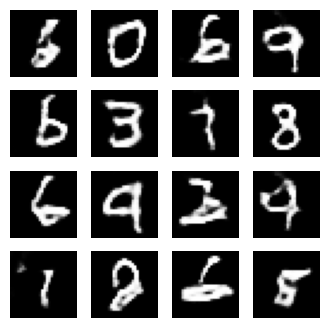

In [48]:
# 產生圖像
def generate_images(model, test_input):
    # 預測
    predictions = model(test_input, training=False)

    # 顯示 4x4 的格子
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

    plt.show()
generate_images(generator, seed)

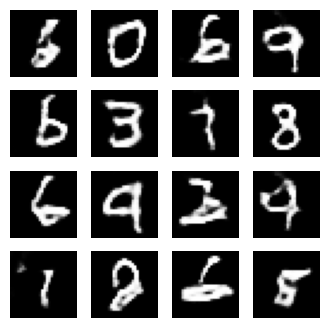

In [49]:
train(train_dataset, 5)